In [1]:
%pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357291 sha256=f67c98ca1382454c2101e701a012c74bf8b570ef6a66ad2329f6248afddc4944
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
%pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 16.6 MB/s eta 0:00:00


In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1636%2F792972%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T203159Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6e3fd2ab55c10ade0430f479818d966568b70e35de0322718acb5cdbbba6af25dff6c08b7109454a4f45e48dbf97f6a0d608bccb9ca474d8b0accfeb84f5e6f744f4bdb54fcb464358d6f267702d2c1fdbcd3c32b77c057fc67f09bc869ccac30b9baeff681366d101277d74af1224c869628c36c10d643ec6cdd62858eb38f1740320d26f02f0aa3aa2ffff5432cb41be65314f730f88f287d1703e8f40fd3ee4cb10024b7ef801b5780704a1b0f0bed181c9fcd59ff711f05e35bf240674b832a539c82f0b251b675b298a736cdb4e9e66d56cb7f75cb3d09c2789210730102395a17f7784c74a9c1c9a1f5c3c4d1fb5029fcd55f75b1cfa2337c8219a0ed4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 716193814 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


Let's import the library we needed before we get started:

In [4]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

import dask.dataframe as dd

Next let's load first data file and get a feeling of how huge the dataset is:

In [5]:
def load_data(path):
    columns = ['Cust_Id', 'Rating', 'Date']
    df = pd.read_csv(path, header = None, names = columns)
    df['Rating'] = df['Rating'].astype(float)
    return df

In [6]:
df1 = load_data('../input/combined_data_1.txt')
df2 = load_data('../input/combined_data_2.txt')
df3 = load_data('../input/combined_data_3.txt')
df4 = load_data('../input/combined_data_4.txt')

In [7]:
df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
print(f'Dataset shape: {df.shape}')

Dataset shape: (100498277, 3)


## Data viewing

In [8]:
df.isnull().sum()

,0
Cust_Id,0
Rating,17770
Date,17770


Let's give a first look on how the data spread:

<ipython-input-9-881a67ca2680>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = df.isnull().sum()[1]
<ipython-input-9-881a67ca2680>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


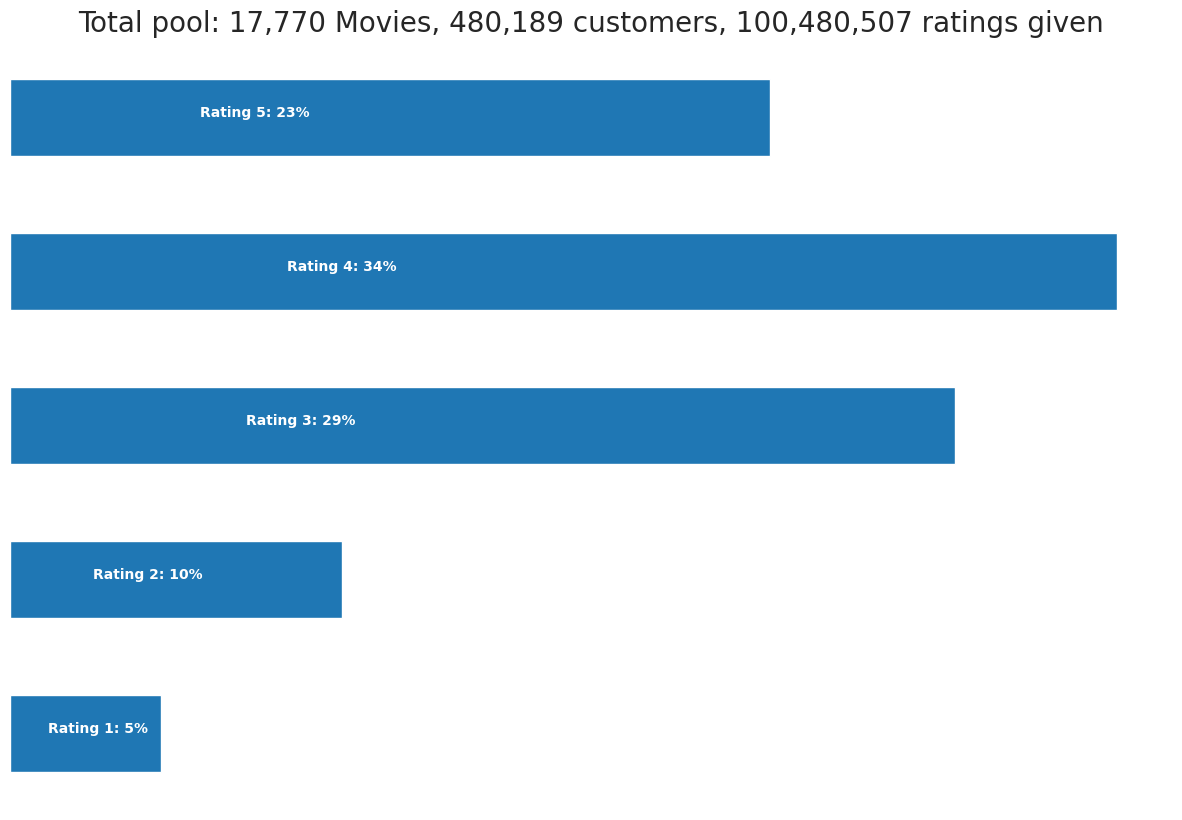

In [9]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [10]:
df['Movie_id'] = df['Rating'].isna().cumsum()
df.dropna(inplace = True)

In [11]:
df['Movie_id'] = df['Movie_id'].astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [12]:
drop_mov_index = df.Movie_id.value_counts()[df.Movie_id.value_counts()> round(df.Movie_id.value_counts().quantile(0.8),0)].index

In [13]:
drop_cust_index = df.Cust_Id.value_counts()[df.Cust_Id.value_counts()> round(df.Cust_Id.value_counts().quantile(0.8),0)].index

In [14]:
df_permanent = df.copy()

In [15]:
df = df[~df.Movie_id.isin(drop_mov_index)]
df = df[~df.Cust_Id.isin(drop_cust_index)]
df.reset_index(drop=True, inplace=True)

In [16]:
df.shape

(3217860, 4)

Now let's trim down our data, whats the difference in data size?

Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [ ]:
# Read in the large CSV using Dask
df_dask = dd.from_pandas(df,npartitions=1000)

# Convert 'Movie_id' to categorical dtype
df_dask['Movie_id'] = df_dask['Movie_id'].astype('category').cat.as_known()

# Create a pivot table using Dask
df_pivot_dask = df_dask.pivot_table(values='Rating', index='Cust_Id', columns='Movie_id', aggfunc='mean')

# Compute the final result
df_pivot = df_pivot_dask.compute()